In [1]:
#PID VALUES FOR GRAPH
kP = 1.5
kI = 0.005
kD = 100.6

In [2]:
from math import sqrt
MAX_RATE = 10
TIME_STEP = 0.02 #50Hz
DEBUG = False
MAX_ACCELERATION = 3

class dot:
    
    max_rate = MAX_RATE
    Max_Acceleration = MAX_ACCELERATION
    IDENTIFICATION = False  
    calc_error = lambda self: self.Target - self.Current

    def __init__(self, Current, Target = False):
        self.Current = Current
        self.Previous = False
        self.Target = Target
        self.Error = self.Target-self.Current if Target else 0
        self.Previous_Error = self.Error
        self.Integral = 0
        self.Velocity = 0
        self.vPrev = 0
        self.reachedTargetCount = 0
        self.DONE = False
        
    def action(self):
        self.movement()
        self.checkDone()
        
    def checkDone(self):
        if abs(self.Target - self.Current) < 0.05:
            self.reachedTargetCount += 1
            if self.reachedTargetCount == 10:
                self.DONE = True
        else:
            self.reachedTargetCount = 0

    def movement(self):
        vDesired = constrainer(self.v_profile(self), self.max_rate)
        self.Velocity = Acceleration_Constrainer(self, vDesired)
        Delta = TIME_STEP*self.Velocity
        self.Previous = self.Current
        self.Current = Delta+self.Current
        self.vPrev = self.Velocity
        
    def __str__(self):
        if self.DONE:
            return self.Target
        if self.IDENTIFICATION:
            return self.IDENTIFICATION + str(round(self.Current, 3))
        return str(round(self.Current, 3))
    
    def __repr__(self):
        return str(self.__str__())

class PID_controller:

    def __init__(self, kP = 1, kI = 0, kD = 0):
        self.kP = kP
        self.kI = kI
        self.kD = kD

    def calc(self, dot):
        return self.kP*dot.Proportion+self.kI*dot.Integral+self.kD*dot.Derivitive

class Frame:

    def __init__(self, dots):
        assert type(dots) == list, "dots should be of type list"
        self.dots = dots

    def addDot(self, dot):
        self.dots.append(dot)

    def update(self):
        for dot in self.dots:
            dot.action()

def PID_profile_maker(PID):
    assert type(PID) == PID_controller, "PID parameter for function PID_profile_maker should be of type PID"
    def v_profile(_dot):
        assert type(_dot) == dot, "Dot must be a parameter to v_profile"
        _dot.Error = _dot.calc_error()
        _dot.Proportion = _dot.Error
        _dot.Integral += _dot.Error*TIME_STEP
        _dot.Derivitive = (_dot.Error-_dot.Previous_Error)/TIME_STEP
        _dot.Previous_Error = _dot.Error
        if(DEBUG):
            print(str(_dot.Error) + ' ' + str(PID.calc(_dot)))
        return PID.calc(_dot)
    return v_profile

#TEST CONTROLLERS
P_C = PID_controller()
PI_C = PID_controller(1, 0.001, 0)
PID_C = PID_controller(1, 0.001, 3)
I_C = PID_controller(0, 0.1, 0)
PD_C = PID_controller(1, 0, 0.1)
D_C = PID_controller(0.001, 0 , 1)

controllers = [P_C, PI_C, PID_C, I_C, PD_C, D_C]
v_profiles = [PID_profile_maker(controller) for controller in controllers]


sgn = lambda number: 0 if number == 0 else (1 if number > 0 else -1)

constrainer = lambda number, constraint: min(number, sgn(number)*constraint, key=abs)

def Acceleration_Constrainer(_dot, vDesired, Time_Step = TIME_STEP):
    if abs(vDesired - _dot.vPrev) > _dot.Max_Acceleration:
        return (sgn(vDesired-_dot.vPrev)*_dot.Max_Acceleration*Time_Step)+_dot.vPrev
    return vDesired



bang_bang = lambda error: sgn(error)
proportional = lambda error: error
quadratic = lambda error: sgn(error)*error**2
square_root = lambda error: sgn(error)*sqrt(abs(error))
rate_arr = [bang_bang, proportional, quadratic, square_root]

range_array = lambda start, end, step: [_ * step for _ in range(int(start*step**-1), int(end*step**-1))]

def rate_test():

    print("-10, 10" +str([rate(error) for rate in rate_arr for error in range(-10,10)]))
    print("-1, 1 s 0.1" +str([rate(error) for rate in rate_arr for error in range_array(-1, 1, 0.1)]))

def test():

    dot_array = [dot(0) for _ in range(len(v_profiles))]
    for d, v_prof in zip(dot_array, v_profiles):
        d.v_profile = v_prof
        d.Target = 500

    test_frame = Frame(dot_array)
    for _ in range(int(TARGET*(1/(TIME_STEP*MAX_RATE)*3))):
        print(str(_)+ ': ', dot_array)
        test_frame.update()



In [3]:
def getData(v_p, startPosition, endPosition):
    data_dot = dot(startPosition)
    data_dot.v_profile = v_p
    data_dot.Target = endPosition
    data_Frame = Frame([data_dot])
    
    dataPos = []
    dataVelo = []
    
    
    watchDog = 0
    
    while(not data_dot.DONE):
        dataPos.append(data_dot.Current)
        dataVelo.append(data_dot.Velocity)
        data_Frame.update()
        watchDog += 1
        if watchDog>1000000:
            data_dot.DONE = True
        #print(data_dot.Current)
    dataPos.append(data_dot.Current)
    dataVelo.append(data_dot.Velocity)
    
    return dataPos, dataVelo


798 798


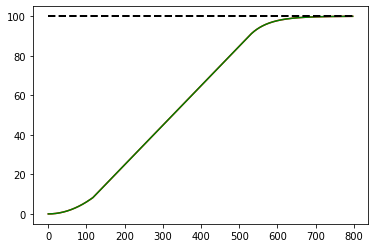

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
Target = 100


Data1Pos, Data1Velo = getData(PID_profile_maker(PID_controller(1.0, 0, 0)), 0, Target)
Data2Pos, Data2Velo = getData(PID_profile_maker(PID_controller(1.0, 0.0, 0.0)), 0, Target)
print(len(Data1Pos), len(Data2Pos))
plt.plot(Data1Pos, color='Red')
plt.plot(Data2Pos, color='Green')
plt.plot([Target]*max(len(Data1Pos), len(Data2Pos)), color='Black', linewidth=2, linestyle='dashed', label="target")

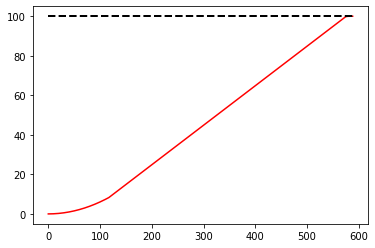

In [5]:
Data3Pos, Data3Velo = getData(PID_profile_maker(PID_controller(17.0, 0, 0)), 0, Target)
plt.plot(Data3Pos, color='Red')
plt.plot([Target]*len(Data3Pos), color='Black', linewidth=2, linestyle='dashed', label="target")

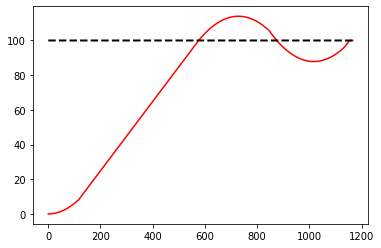

In [6]:
Data3Pos, Data3Velo = getData(PID_profile_maker(PID_controller(18.0, 0, 0)), 0, Target)
plt.plot(Data3Pos, color='Red')
plt.plot([Target]*len(Data3Pos), color='Black', linewidth=2, linestyle='dashed', label="target")

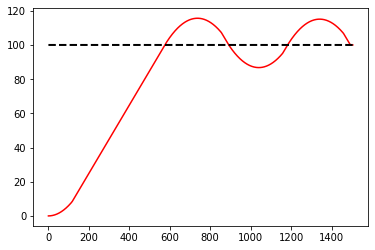

In [7]:
Data3Pos, Data3Velo = getData(PID_profile_maker(PID_controller(19, 0, 0)), 0, Target)
plt.plot(Data3Pos, color='Red')
plt.plot([Target]*len(Data3Pos), color='Black', linewidth=2, linestyle='dashed', label="target")

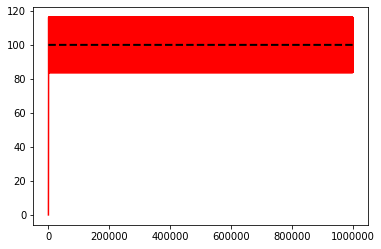

In [8]:
Data3Pos, Data3Velo = getData(PID_profile_maker(PID_controller(21, 0, 0)), 0, Target)
plt.plot(Data3Pos, color='Red')
plt.plot([Target]*len(Data3Pos), color='Black', linewidth=2, linestyle='dashed', label="target")

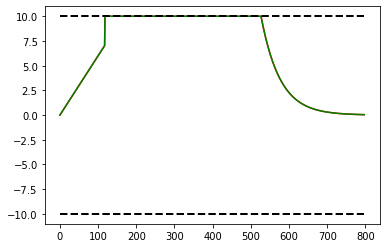

In [9]:
plt.plot(Data1Velo, color='Red')
plt.plot(Data2Velo, color='Green')
plt.plot([dot.max_rate]*max(len(Data1Pos), len(Data2Pos)), color='Black', linewidth=2, linestyle='dashed', label="target")
plt.plot([-dot.max_rate]*max(len(Data1Pos), len(Data2Pos)), color='Black', linewidth=2, linestyle='dashed', label="target")